## LangChain: Chains
It is one of the most important key building block of LangChain, namely the `Chain`. The chain usually combines an LLM (Large Language Model) together with a prompt and with this building block, and you can put bunch of these building blocks together to carry out a sequence of operations on your text or your other data. 

Using an LLM in isolation is fine for simple applications, but more complex applications require chaining LLMs - either with each other or with other components.

LangChain provides the Chain interface for such "chained" applications. We define a Chain very generically as a sequence of calls to components, which can include other chains.

### Outline
- LLMChain
- Sequential Chains
  - SimpleSequentialChain
  - SequentialChain
- Router Chain

In [2]:
import openai
import os

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

OPENAI_KEY = os.getenv('OPENAI_KEY')
openai.api_key = OPENAI_KEY

In [3]:
import pandas as pd
df = pd.read_csv("Data.csv")
df.head()

,Product,Review
0,Queen Size Sheet Set,I ordered a king size set. My only criticism w...
1,Waterproof Phone Pouch,"I loved the waterproof sac, although the openi..."
2,Luxury Air Mattress,This mattress had a small hole in the top of i...
3,Pillows Insert,This is the best throw pillow fillers on Amazo...
4,Milk Frother Handheld\n,I loved this product. But they only seem to l...


In [7]:
from langchain.chat_models import ChatOpenAI
llm = ChatOpenAI(temperature=0.9, model="gpt-3.5-turbo", openai_api_key=OPENAI_KEY)

#### LLMChain
A LLMChain is the most common type of chain. It consists of a PromptTemplate, a model (either an LLM or a ChatModel), and an optional output parser. This chain takes multiple input variables, uses the PromptTemplate to format them into a prompt. It then passes that to the model. Finally, it uses the OutputParser (if provided) to parse the output of the LLM into a final format.

In [8]:
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain

prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe \
    a company that makes {product}?"
)

In [9]:
chain = LLMChain(llm=llm, prompt=prompt)

product = "Qeen Size Sheet Set"
chain.run(product)

'"Royal Comfort Linens"'

#### Sequential Chains
The next step after calling a language model is to make a series of calls to a language model. This is particularly useful when you want to take the output from one call and use it as the input to another.

It is another type of chains. The idea is to combine multiple chains where the output of the once chain is the input of the next chain.
There is two types of sequential chains:
1. SimpleSequentialChain: Single input/output
2. SequentialChain: multiple inputs/outputs

#### 1. SimpleSequentialChain
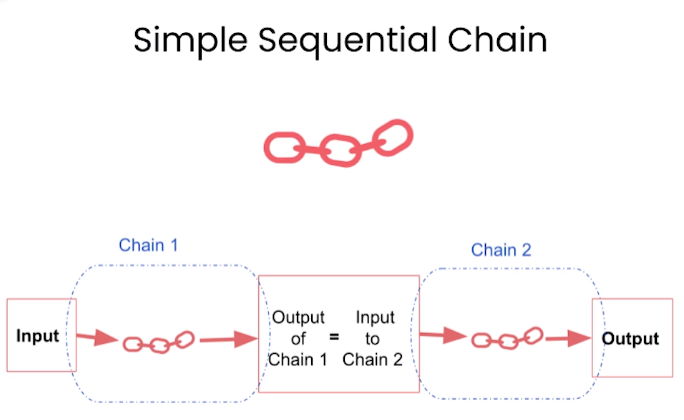

In [10]:
from langchain.chains import SimpleSequentialChain

# prompt template 1
first_prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe \
    a company that makes {product}?"
)

# Chain 1
chain_one = LLMChain(llm=llm, prompt=first_prompt)

In [11]:
# prompt template 2
second_prompt = ChatPromptTemplate.from_template(
    "Write a 20 words description for the following \
    company:{company_name}"
)
# chain 2
chain_two = LLMChain(llm=llm, prompt=second_prompt)

In [12]:
overall_simple_chain = SimpleSequentialChain(chains=[chain_one, chain_two],
                                             verbose=True
                                            )

In [14]:
product = "Queen Size Sheet Set"
overall_simple_chain.run(product)



> Entering new SimpleSequentialChain chain...
Royal Comfort Linens
Royal Comfort Linens is a high-quality bedding and linen company that offers luxurious and comfortable products for a peaceful sleep.

> Finished chain.


'Royal Comfort Linens is a high-quality bedding and linen company that offers luxurious and comfortable products for a peaceful sleep.'

#### 2. SequentialChain
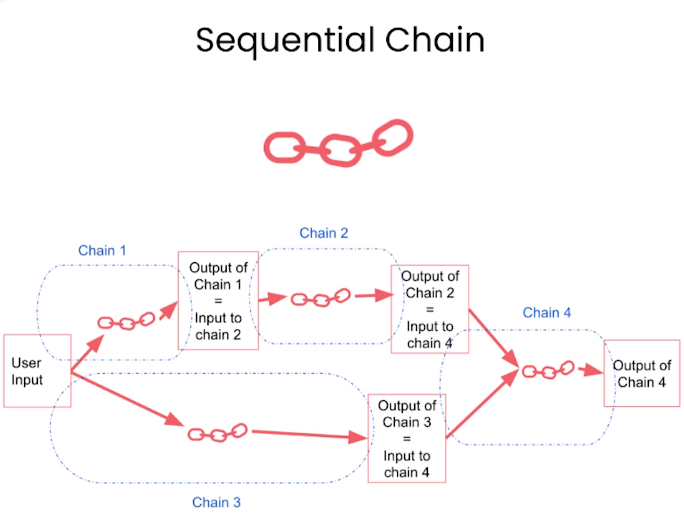

In [17]:
from langchain.chains import SequentialChain

# prompt template 1: translate to english
first_prompt = ChatPromptTemplate.from_template(
    "Translate the following review to english:"
    "\n\n{Review}"
)
# chain 1: input= Review and output= English_Review
chain_one = LLMChain(llm=llm, prompt=first_prompt, 
                     output_key="English_Review"
                    )

second_prompt = ChatPromptTemplate.from_template(
    "Can you summarize the following review in 1 sentence:"
    "\n\n{English_Review}"
)
# chain 2: input= English_Review and output= summary
chain_two = LLMChain(llm=llm, prompt=second_prompt, 
                     output_key="summary"
                    )


# prompt template 3: translate to english
third_prompt = ChatPromptTemplate.from_template(
    "What language is the following review:\n\n{Review}"
)
# chain 3: input= Review and output= language
chain_three = LLMChain(llm=llm, prompt=third_prompt,
                       output_key="language"
                      )

# prompt template 4: follow up message
fourth_prompt = ChatPromptTemplate.from_template(
    "Write a follow up response to the following "
    "summary in the specified language:"
    "\n\nSummary: {summary}\n\nLanguage: {language}"
)
# chain 4: input= summary, language and output= followup_message
chain_four = LLMChain(llm=llm, prompt=fourth_prompt,
                      output_key="followup_message"
                     )

In [18]:
# overall_chain: input= Review 
# and output= English_Review,summary, followup_message
overall_chain = SequentialChain(
    chains=[chain_one, chain_two, chain_three, chain_four],
    input_variables=["Review"],
    output_variables=["English_Review", "summary","followup_message"],
    verbose=True
)

In [20]:
review = df.Review[5]
review

"Je trouve le goût médiocre. La mousse ne tient pas, c'est bizarre. J'achète les mêmes dans le commerce et le goût est bien meilleur...\nVieux lot ou contrefaçon !?"

In [21]:
overall_chain(review)



> Entering new SequentialChain chain...

> Finished chain.


{'Review': "Je trouve le goût médiocre. La mousse ne tient pas, c'est bizarre. J'achète les mêmes dans le commerce et le goût est bien meilleur...\nVieux lot ou contrefaçon !?",
 'English_Review': "I find the taste mediocre. The foam doesn't hold, it's weird. I buy the same ones in stores and the taste is much better... Old batch or counterfeit!?",
 'summary': 'The reviewer is disappointed with the taste and foam quality of the product, suspecting that it may be an old batch or counterfeit compared to the ones bought in stores.',
 'followup_message': "Cher(e) client(e),\n\nNous vous remercions sincèrement d'avoir partagé votre expérience avec notre produit. Nous sommes vraiment désolés d'apprendre que vous avez été déçu(e) par le goût et la qualité de la mousse de notre produit.\n\nNous tenons à vous assurer que nous prenons très au sérieux vos préoccupations et que nous souhaitons résoudre ce problème rapidement. Nous enquêtons actuellement sur la situation afin de déterminer si cela 

#### 3. Router Chain

RouterChain creates a chain that dynamically selects the next chain to use for a given input.

Router chains are made up of two components:
- The `RouterChain` itself (responsible for selecting the next chain to call)
- `destination_chains`: chains that the router chain can route to

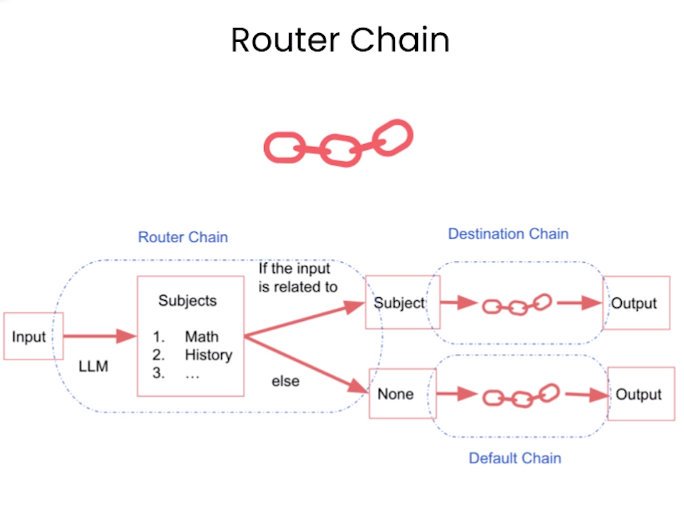

In [24]:
## different templates

physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise\
and easy to understand manner. \
When you don't know the answer to a question you admit\
that you don't know.

Here is a question:
{input}"""


math_template = """You are a very good mathematician. \
You are great at answering math questions. \
You are so good because you are able to break down \
hard problems into their component parts, 
answer the component parts, and then put them together\
to answer the broader question.

Here is a question:
{input}"""

history_template = """You are a very good historian. \
You have an excellent knowledge of and understanding of people,\
events and contexts from a range of historical periods. \
You have the ability to think, reflect, debate, discuss and \
evaluate the past. You have a respect for historical evidence\
and the ability to make use of it to support your explanations \
and judgements.

Here is a question:
{input}"""


computerscience_template = """ You are a successful computer scientist.\
You have a passion for creativity, collaboration,\
forward-thinking, confidence, strong problem-solving capabilities,\
understanding of theories and algorithms, and excellent communication \
skills. You are great at answering coding questions. \
You are so good because you know how to solve a problem by \
describing the solution in imperative steps \
that a machine can easily interpret and you know how to \
choose a solution that has a good balance between \
time complexity and space complexity. 

Here is a question:
{input}"""

prompt_infos = [
    {
        "name": "physics", 
        "description": "Good for answering questions about physics", 
        "prompt_template": physics_template
    },
    {
        "name": "math", 
        "description": "Good for answering math questions", 
        "prompt_template": math_template
    },
    {
        "name": "History", 
        "description": "Good for answering history questions", 
        "prompt_template": history_template
    },
    {
        "name": "computer science", 
        "description": "Good for answering computer science questions", 
        "prompt_template": computerscience_template
    }
]
# PS: prompt_infos: information is then passed to the router chain so that it can decide when to use this sub-chain.

In [27]:
from langchain.chains.router import MultiPromptChain ## required when routing between multiple different routing chains.
from langchain.chains.router.llm_router import LLMRouterChain,RouterOutputParser
from langchain.prompts import PromptTemplate

In [25]:
llm = ChatOpenAI(temperature=0.0, model="gpt-3.5-turbo", openai_api_key=OPENAI_KEY)

In [31]:
## We'll now create destination chains.
destination_chains = {}
for p_info in prompt_infos:
    name = p_info["name"]
    prompt_template = p_info["prompt_template"]
    prompt = ChatPromptTemplate.from_template(template=prompt_template)
    chain = LLMChain(llm=llm, prompt=prompt)
    destination_chains[name] = chain  
    
destinations = [f"{p['name']}: {p['description']}" for p in prompt_infos]
destinations_str = "\n".join(destinations)

In [28]:
default_prompt = ChatPromptTemplate.from_template("{input}")
default_chain = LLMChain(llm=llm, prompt=default_prompt) ## Needed, when Router chain cannot decide which of the subchain to use.

In [29]:
MULTI_PROMPT_ROUTER_TEMPLATE = """Given a raw text input to a \
language model select the model prompt best suited for the input. \
You will be given the names of the available prompts and a \
description of what the prompt is best suited for. \
You may also revise the original input if you think that revising\
it will ultimately lead to a better response from the language model.

<< FORMATTING >>
Return a markdown code snippet with a JSON object formatted to look like:
```json
{{{{
    "destination": string \ name of the prompt to use or "DEFAULT"
    "next_inputs": string \ a potentially modified version of the original input
}}}}
```

REMEMBER: "destination" MUST be one of the candidate prompt \
names specified below OR it can be "DEFAULT" if the input is not\
well suited for any of the candidate prompts.
REMEMBER: "next_inputs" can just be the original input \
if you don't think any modifications are needed.

<< CANDIDATE PROMPTS >>
{destinations}

<< INPUT >>
{{input}}

<< OUTPUT (remember to include the ```json)>>"""

In [32]:
router_template = MULTI_PROMPT_ROUTER_TEMPLATE.format(
    destinations=destinations_str
)
router_prompt = PromptTemplate(
    template=router_template,
    input_variables=["input"],
    output_parser=RouterOutputParser(),
)

router_chain = LLMRouterChain.from_llm(llm, router_prompt)

In [33]:
chain = MultiPromptChain(router_chain=router_chain, 
                         destination_chains=destination_chains, 
                         default_chain=default_chain, verbose=True
                        )

In [36]:
print(chain.run("What is black body radiations?"))



> Entering new MultiPromptChain chain...
physics: {'input': 'What is black body radiation?'}
> Finished chain.
Black body radiation refers to the electromagnetic radiation emitted by an object that absorbs all incident radiation and reflects or transmits none. It is called "black body" because it absorbs all wavelengths of light, appearing black at room temperature. 

According to Planck's law, the intensity and distribution of this radiation depend on the temperature of the object. As the temperature increases, the peak of the radiation shifts to shorter wavelengths, resulting in a change in color from red to orange, yellow, white, and eventually blue at very high temperatures.

Black body radiation is a fundamental concept in physics and has been crucial in understanding various phenomena, such as the ultraviolet catastrophe and the development of quantum mechanics. It has applications in astrophysics, thermodynamics, and the study of the cosmic microwave background radiation, amon

In [38]:
print(chain.run("what is 2 + 2"))



> Entering new MultiPromptChain chain...
math: {'input': 'what is 2 + 2'}
> Finished chain.
Thank you for your kind words! As a mathematician, I am happy to help with any math questions, no matter how simple or complex they may be.

Now, let's solve the problem at hand. The question is asking for the sum of 2 and 2. To find the answer, we can simply add the two numbers together:

2 + 2 = 4

Therefore, the sum of 2 and 2 is 4.


In [39]:
chain.run("Why does every cell in our body contain DNA?")



> Entering new MultiPromptChain chain...
None: {'input': 'Why does every cell in our body contain DNA?'}
> Finished chain.


'Every cell in our body contains DNA because DNA is the genetic material that carries the instructions for the development, functioning, and reproduction of all living organisms. DNA contains the information necessary for the synthesis of proteins, which are essential for the structure and function of cells. It serves as a blueprint for the production of specific proteins that determine the characteristics and traits of an organism. Additionally, DNA is responsible for the transmission of genetic information from one generation to the next during reproduction. Therefore, every cell in our body contains DNA to ensure the proper functioning and continuity of life.'